### Dependencies

In [1]:
# CS194-26 (CS294-26): Project 1 starter Python code

# these are just some suggested libraries
# instead of scikit-image you could use matplotlib and opencv to read, write, and display images

import numpy as np
import skimage as sk
import skimage.io as skio
from skimage import img_as_float
from skimage.transform import rescale
from scipy.ndimage import shift
from skimage import feature
from skimage.transform import pyramid_gaussian

### Low quality photos

In [2]:
def center(img):
    height, width = img.shape

    top = int(height / 4)
    bottom = int(3 * height / 4)
    left = int(width / 4)
    right = int(3 * width / 4)

    return img[top:bottom, left:right]

def image_pyramid(img1, img2, num_levels):
    scaled1_blue = list(pyramid_gaussian(img1, downscale = num_levels))
    scaled2_blue = list(pyramid_gaussian(img2, downscale = num_levels))

def normalized_cross_correlation(arr1: np.ndarray, arr2: np.ndarray) -> float:
    arr1_norm = (arr1 - np.mean(arr1)) / np.std(arr1)
    arr2_norm = (arr2 - np.mean(arr2)) / np.std(arr2)
    ncc = np.sum(arr1_norm * arr2_norm)

    return ncc

def align(im1: np.ndarray, im2: np.ndarray, max_shift: int = 15, initial_shift=(0, 0)):
    best_dx, best_dy = initial_shift
    max_ncc = -float('inf')

    for dx in range(- max_shift, max_shift + 1):
        for dy in range(- max_shift, max_shift + 1):
            # Shift im2 by (dx, dy)
            shifted_im2 = np.roll(im2, dx, axis = 1)
            shifted_im2 = np.roll(shifted_im2, dy, axis = 0)
            
            # Compute NCC
            ncc = normalized_cross_correlation(center(im1), center(shifted_im2))

            # Update best shift
            if ncc > max_ncc:
                max_ncc = ncc
                best_dx, best_dy = dx, dy
    
    # Apply best shift
    # aligned_im2 = np.roll(im2, (best_dy, best_dx), axis=(0, 1))
    aligned_im2 = np.roll(np.roll(im2, best_dy, axis=0), best_dx, axis=1)
    
    # Print best shift for debugging purposes
    print(f"Best shift: ({best_dx}, {best_dy})")
    
    return aligned_im2

In [ ]:
# Example usage
# imname = 'monastery.jpg'
imname = 'cathedral.jpg'
# imname = 'tobolsk.jpg'

# read in the image
im = skio.imread('../data/' + imname)
# im = skio.imread('../data/three_generations.tif')

# convert to double (might want to do this later on to save memory)    
im = img_as_float(im)

# compute the height of each part (just 1/3 of total)
height = np.floor(im.shape[0] / 3.0).astype(int)

# separate color channels
b = im[:height]
g = im[height:2 * height]
r = im[2 * height:3 * height]

# align the flattened images
ag = align(b, g)
ar = align(b, r)

# Create a color image
im_out = np.dstack([ar, ag, b])

# Display the image
skio.imshow(im_out)
skio.show()

# Image Pyramids

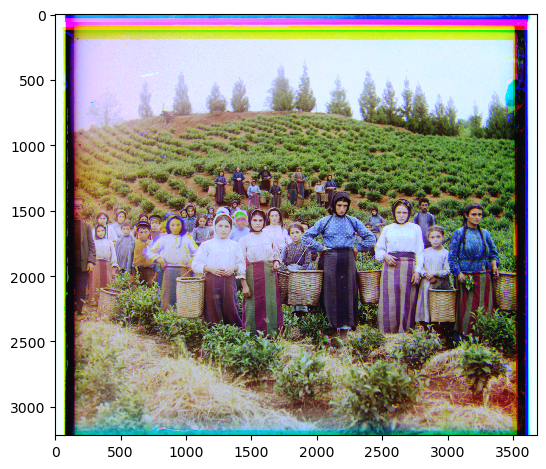

In [14]:
import numpy as np
import skimage.io as skio
from skimage import img_as_float
from scipy.ndimage import convolve

def center(img):
    height, width = img.shape
    
    top = int(height / 4)
    bottom = int(3 * height / 4)
    left = int(width / 4)
    right = int(3 * width / 4)

    return img[top:bottom, left:right]

def normalized_cross_correlation(arr1: np.ndarray, arr2: np.ndarray) -> float:
    arr1_norm = (arr1 - np.mean(arr1)) / np.std(arr1)
    arr2_norm = (arr2 - np.mean(arr2)) / np.std(arr2)
    ncc = np.sum(arr1_norm * arr2_norm)

    return ncc

        # green/red,         blue
def align(im1: np.ndarray, im2: np.ndarray, max_shift: int = 20, initial_shift = (0, 0)):
    best_dx, best_dy = initial_shift
    max_ncc = -float('inf')

    for dx in range(-max_shift, max_shift + 1):
        for dy in range(-max_shift, max_shift + 1):
            # Shift im2 by (dx, dy)
            shifted_im1 = np.roll(im1, dx, axis = 1)  # Shift in x
            shifted_im1 = np.roll(shifted_im1, dy, axis = 0)  # Shift in y

            # Compute NCC on the centered image to avoid edge effects
            ncc = normalized_cross_correlation(center(im2), center(shifted_im1))

            # Update best shift
            if ncc > max_ncc:
                max_ncc = ncc
                best_dx, best_dy = dx, dy

    return best_dx, best_dy


def pyramid_scaledown(img, kernelsize = 3, stride = 3): 
    kernel = np.ones((kernelsize, kernelsize)) / (kernelsize * kernelsize) # average filter due to normalizing the kernel
    scaled_img = convolve(img, kernel, mode='reflect')
    scaled_img = scaled_img[::stride, ::stride]
    return scaled_img

def align_with_pyramid(im1: np.ndarray, im2: np.ndarray):
    max_ncc = -float('inf')
    best_dx, best_dy = 0, 0

    scaled1_blue = pyramid_scaledown(im2)
    scaled2_blue = pyramid_scaledown(scaled1_blue)
    scaled1_img1 = pyramid_scaledown(im1)
    scaled2_img1 = pyramid_scaledown(scaled1_img1)
    
    max_shift = 32  # Initial max shift for the smallest level

    shift_dx, shift_dy = align(center(scaled2_img1), center(scaled2_blue), max_shift = max_shift)

    for dx in range(shift_dx * 3 - 3, shift_dx * 3 + 3 + 1):
        for dy in range(shift_dy * 3 - shift_dy, shift_dy * 3 + 3 + 1):
            # Shift im2 by (dx, dy)
            shifted_im1= np.roll(scaled1_img1, dx, axis = 1)  # Shift in x
            shifted_im1 = np.roll(shifted_im1, dy, axis = 0)  # Shift in y

            # Compute NCC on the centered image to avoid edge effects
            ncc = normalized_cross_correlation(center(shifted_im1), center(scaled1_blue))

            # Update best shift
            if ncc > max_ncc:
                max_ncc = ncc
                best_dx, best_dy = dx, dy

    max_ncc = float('-inf') 

    for dx in range(best_dx * 3 - 3, best_dx * 3 + 3 + 1):
        for dy in range(best_dy * 3 - 3, best_dy * 3 + 3 + 1):
            # Shift im2 by (dx, dy)
            shifted_im1 = np.roll(im1, dx, axis = 1)  # Shift in x
            shifted_im1 = np.roll(shifted_im1, dy, axis = 0)  # Shift in y

            # Compute NCC on the centered image to avoid edge effects
            ncc = normalized_cross_correlation(center(shifted_im1), center(im2))

            # Update best shift
            if ncc > max_ncc:
                max_ncc = ncc
                best_dx, best_dy = dx, dy
                best_align = shifted_im1

    return best_align, best_dx, best_dy

def auto_contrast(image):
    # Compute the frequency of each pixel intensity value
    freq = np.zeros(256, dtype=int)
    for pixel in image.flatten():
        freq[int(pixel * 255)] += 1

    # Compute the prefix sum of the frequency array
    prefix = np.cumsum(freq)

    # Total number of pixels in the image
    total = prefix[-1]

    # Normalize the prefix sum to get the proportion of pixels with intensity <= i
    normalized_prefix = prefix / total

    # Reassign each pixel intensity based on the normalized prefix sum
    new_image = np.interp(image.flatten(), np.linspace(0, 1, 256), normalized_prefix * 255).reshape(image.shape)

    return new_image / 255.0

def auto_white_balance(image, gray_point = 0.55):
    # Compute the average color vector
    avg_color = np.mean(image, axis=(0, 1))

    # Perform white balancing
    balanced_image = image / avg_color * gray_point

    # Clip values to be in the valid range [0, 1]
    balanced_image = np.clip(balanced_image, 0, 1)

    return balanced_image

# Example usage
im = skio.imread('../data/harvesters.tif')
im = img_as_float(im)

# Compute the height of each part (just 1/3 of total)
height = np.floor(im.shape[0] / 3.0).astype(int)

# Separate color channels
b = im[:height]
g = im[height:2 * height]
r = im[2 * height:3 * height]

# Align using the image pyramid
ar, dx_r, dy_r = align_with_pyramid(r, b)
ag, dx_g, dy_g = align_with_pyramid(g, b)

ar = np.roll(r, dx_r, axis = 1)
ar = np.roll(ar, dy_r, axis = 0)

ag = np.roll(g, dx_g, axis = 1)
ag = np.roll(ag, dy_g, axis = 0)

# Create a color image
im_out = np.dstack([ar, ag, b])

# Apply auto contrast to the final aligned image
im_out = auto_contrast(im_out)

# Apply auto white balance to the final aligned image
im_out = auto_white_balance(im_out)

# Display the image
skio.imshow(im_out)
skio.show()

### Sobel Filter

Green channel alignment: dx = 21, dy = 49
Red channel alignment: dx = 36, dy = 108


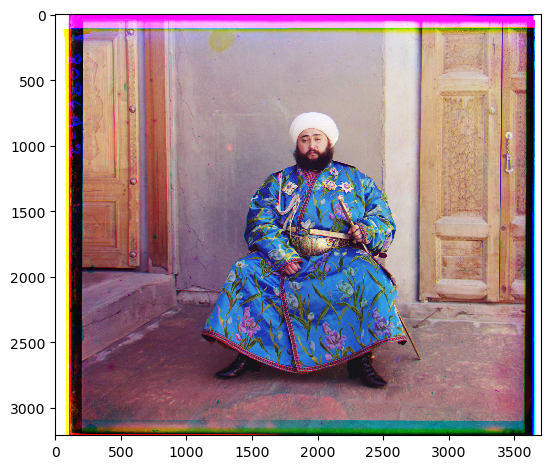

In [2]:
import numpy as np
import skimage.io as skio
from skimage import img_as_float
from scipy.ndimage import convolve
import cv2

# Sobel filter for edge detection
def sobel_filter(image):
    sobel_x = cv2.Sobel(image, cv2.CV_64F, 1, 0, ksize=3)
    sobel_y = cv2.Sobel(image, cv2.CV_64F, 0, 1, ksize=3)
    sobel_edges = np.hypot(sobel_x, sobel_y)
    return sobel_edges

# Same alignment and pyramid functions as provided, no changes here

# Read in the image
im = skio.imread('../data/emir.tif')

# Convert to float
im = img_as_float(im)

# Compute the height of each part (1/3 of total height)
height = np.floor(im.shape[0] / 3.0).astype(int)

# Separate color channels
b = im[:height]
g = im[height:2 * height]
r = im[2 * height:3 * height]

# Apply Sobel filter to get edges
b_edges = sobel_filter(b)
g_edges = sobel_filter(g)
r_edges = sobel_filter(r)

# Align green and red channels to blue (using the Sobel edges)
ag_edges, dx_g, dy_g = align_with_pyramid(g_edges, b_edges)
ar_edges, dx_r, dy_r = align_with_pyramid(r_edges, b_edges)

# Print alignment results for each color channel
print(f"Green channel alignment: dx = {dx_g}, dy = {dy_g}")
print(f"Red channel alignment: dx = {dx_r}, dy = {dy_r}")

# Now align the original channels (not Sobel-filtered)
# Use the calculated shifts (dx_g, dy_g) and (dx_r, dy_r) from the Sobel-filtered images
ag = np.roll(g, dx_g, axis=1)
ag = np.roll(ag, dy_g, axis=0)

ar = np.roll(r, dx_r, axis=1)
ar = np.roll(ar, dy_r, axis=0)

# Stack the aligned channels to form the final color image
im_out = np.dstack([ar, ag, b])

# Display the final aligned image
skio.imshow(im_out)
skio.show()


# Iterate

In [1]:
import os
import numpy as np
import skimage.io as skio
from skimage import img_as_float
from scipy.ndimage import convolve

def center(img):
    height, width = img.shape
    
    top = int(height / 4)
    bottom = int(3 * height / 4)
    left = int(width / 4)
    right = int(3 * width / 4)

    return img[top:bottom, left:right]

def normalized_cross_correlation(arr1: np.ndarray, arr2: np.ndarray) -> float:
    arr1_norm = (arr1 - np.mean(arr1)) / np.std(arr1)
    arr2_norm = (arr2 - np.mean(arr2)) / np.std(arr2)
    ncc = np.sum(arr1_norm * arr2_norm)

    return ncc

def align(im1: np.ndarray, im2: np.ndarray, max_shift: int = 20, initial_shift = (0, 0)):
    best_dx, best_dy = initial_shift
    max_ncc = -float('inf')

    for dx in range(-max_shift, max_shift + 1):
        for dy in range(-max_shift, max_shift + 1):
            # Shift im2 by (dx, dy)
            shifted_im1 = np.roll(im1, dx, axis = 1)  # Shift in x
            shifted_im1 = np.roll(shifted_im1, dy, axis = 0)  # Shift in y

            # Compute NCC on the centered image to avoid edge effects
            ncc = normalized_cross_correlation(center(im2), center(shifted_im1))

            # Update best shift
            if ncc > max_ncc:
                max_ncc = ncc
                best_dx, best_dy = dx, dy

    return best_dx, best_dy

def pyramid_scaledown(img, kernelsize = 3, stride = 3): 
    kernel = np.ones((kernelsize, kernelsize)) / (kernelsize * kernelsize) # average filter due to normalizing the kernel
    scaled_img = convolve(img, kernel, mode='reflect')
    scaled_img = scaled_img[::stride, ::stride]
    return scaled_img

def align_with_pyramid(im1: np.ndarray, im2: np.ndarray):
    max_ncc = -float('inf')
    best_dx, best_dy = 0, 0

    scaled1_blue = pyramid_scaledown(im2)
    scaled2_blue = pyramid_scaledown(scaled1_blue)
    scaled1_img1 = pyramid_scaledown(im1)
    scaled2_img1 = pyramid_scaledown(scaled1_img1)
    
    max_shift = 32  # Initial max shift for the smallest level

    shift_dx, shift_dy = align(center(scaled2_img1), center(scaled2_blue), max_shift = max_shift)

    for dx in range(shift_dx * 3 - 3, shift_dx * 3 + 3 + 1):
        for dy in range(shift_dy * 3 - shift_dy, shift_dy * 3 + 3 + 1):
            # Shift im2 by (dx, dy)
            shifted_im1= np.roll(scaled1_img1, dx, axis = 1)  # Shift in x
            shifted_im1 = np.roll(shifted_im1, dy, axis = 0)  # Shift in y

            # Compute NCC on the centered image to avoid edge effects
            ncc = normalized_cross_correlation(center(shifted_im1), center(scaled1_blue))

            # Update best shift
            if ncc > max_ncc:
                max_ncc = ncc
                best_dx, best_dy = dx, dy

    max_ncc = float('-inf') 

    for dx in range(best_dx * 3 - 3, best_dx * 3 + 3 + 1):
        for dy in range(best_dy * 3 - 3, best_dy * 3 + 3 + 1):
            # Shift im2 by (dx, dy)
            shifted_im1 = np.roll(im1, dx, axis = 1)  # Shift in x
            shifted_im1 = np.roll(shifted_im1, dy, axis = 0)  # Shift in y

            # Compute NCC on the centered image to avoid edge effects
            ncc = normalized_cross_correlation(center(shifted_im1), center(im2))

            # Update best shift
            if ncc > max_ncc:
                max_ncc = ncc
                best_dx, best_dy = dx, dy
                best_align = shifted_im1

    return best_align, best_dx, best_dy

def auto_contrast(image):
    # Compute the frequency of each pixel intensity value
    freq = np.zeros(256, dtype=int)
    for pixel in image.flatten():
        freq[int(pixel * 255)] += 1

    # Compute the prefix sum of the frequency array
    prefix = np.cumsum(freq)

    # Total number of pixels in the image
    total = prefix[-1]

    # Normalize the prefix sum to get the proportion of pixels with intensity <= i
    normalized_prefix = prefix / total

    # Reassign each pixel intensity based on the normalized prefix sum
    new_image = np.interp(image.flatten(), np.linspace(0, 1, 256), normalized_prefix * 255).reshape(image.shape)

    return new_image / 255.0

def auto_white_balance(image, gray_point = 0.55):
    # Compute the average color vector
    avg_color = np.mean(image, axis=(0, 1))

    # Perform white balancing
    balanced_image = image / avg_color * gray_point

    # Clip values to be in the valid range [0, 1]
    balanced_image = np.clip(balanced_image, 0, 1)

    return balanced_image

def process_image_file(file_path):
    im = skio.imread(file_path)
    im = img_as_float(im)

    # Compute the height of each part (just 1/3 of total)
    height = np.floor(im.shape[0] / 3.0).astype(int)

    # Separate color channels
    b = im[:height]
    g = im[height:2 * height]
    r = im[2 * height:3 * height]

    # Align using the image pyramid
    ar, dx_r, dy_r = align_with_pyramid(r, b)
    ag, dx_g, dy_g = align_with_pyramid(g, b)

    ar = np.roll(r, dx_r, axis = 1)
    ar = np.roll(ar, dy_r, axis = 0)

    ag = np.roll(g, dx_g, axis = 1)
    ag = np.roll(ag, dy_g, axis = 0)

    print(f"File: {file_path}")
    print(f"Red channel alignment: dx = {dx_r}, dy = {dy_r}")
    print(f"Green channel alignment: dx = {dx_g}, dy = {dy_g}")

def main(folder_path):
    for filename in os.listdir(folder_path):
        if filename.endswith('.tif'):
            file_path = os.path.join(folder_path, filename)
            process_image_file(file_path)

# Example usage
folder_path = '../data/'  # Change this to your folder path
main(folder_path)

File: ../data/emir.tif
Red channel alignment: dx = -2, dy = 12
Green channel alignment: dx = 21, dy = 48
File: ../data/church.tif
Red channel alignment: dx = -6, dy = 58
Green channel alignment: dx = 0, dy = 25
File: ../data/three_generations.tif
Red channel alignment: dx = 9, dy = 111
Green channel alignment: dx = 12, dy = 51
File: ../data/melons.tif
Red channel alignment: dx = 12, dy = 178
Green channel alignment: dx = 6, dy = 81
File: ../data/onion_church.tif
Red channel alignment: dx = 33, dy = 109
Green channel alignment: dx = 24, dy = 51
File: ../data/train.tif
Red channel alignment: dx = 30, dy = 86
Green channel alignment: dx = 3, dy = 42
File: ../data/icon.tif
Red channel alignment: dx = 21, dy = 90
Green channel alignment: dx = 15, dy = 41
File: ../data/self_portrait.tif
Red channel alignment: dx = 33, dy = 175
Green channel alignment: dx = 27, dy = 77
File: ../data/harvesters.tif
Red channel alignment: dx = 12, dy = 123
Green channel alignment: dx = 15, dy = 59
File: ../data